In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

# import statsmodels.api as sm
# import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N_SIMS = 1000
SEED = 0

In [3]:
UPCOMING_SEASON = 2122
CLUB_TO_PREDICT = 'Brighton'

USE_MULTIPLE_SEASONS = False

In [4]:
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['pdf.fonttype'] = 42 # for Illustrator text compatibility
mpl.rcParams['ps.fonttype'] = 42 # for Illustrator text compatibility

In [30]:
rng = np.random.default_rng(SEED)

In [5]:
historical_seasons = [1617, 1718, 1819] # exclude 1920 and 2021 due to covid impact
latest_season = historical_seasons[-1]

In [6]:
if USE_MULTIPLE_SEASONS:
    seasons = historical_seasons
else:
    seasons = [latest_season]

In [7]:
league_data_url_base = 'https://www.football-data.co.uk/mmz4281/'
league_data_url_end = '/E0.csv'

In [8]:
season_summaries = []

for season in seasons:
    summary_url = league_data_url_base + str(season) + league_data_url_end
    #print(summary_url)
    temp_season = pd.read_csv(summary_url)
    temp_season['season_id'] = season
    season_summaries.append(temp_season)

df_historical_data = pd.concat(season_summaries)

In [9]:
df_historical_data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,season_id
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69,1819
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70,1819
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90,1819
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58,1819
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89,1819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,E0,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,...,22,-1.50,1.98,1.91,2.01,1.95,1.32,5.89,9.48,1819
376,E0,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,...,21,-2.00,2.52,2.32,1.72,1.64,1.30,6.06,9.71,1819
377,E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,...,22,-1.50,2.27,2.16,1.80,1.73,1.37,5.36,8.49,1819
378,E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,...,19,-0.50,2.13,2.08,1.85,1.80,1.91,3.81,4.15,1819


In [10]:
df_goals_by_team = pd.concat([df_historical_data[['HomeTeam','AwayTeam','FTHG']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','FTHG':'goals'}),
           df_historical_data[['AwayTeam','HomeTeam','FTAG']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','FTAG':'goals'})])

df_goals_by_team

,team,opponent,goals,home
0,Man United,Leicester,2,1
1,Bournemouth,Cardiff,2,1
2,Fulham,Crystal Palace,0,1
3,Huddersfield,Chelsea,0,1
4,Newcastle,Tottenham,1,1
...,...,...,...,...
375,Wolves,Liverpool,0,0
376,Cardiff,Man United,2,0
377,Huddersfield,Southampton,1,0
378,Everton,Tottenham,2,0


In [11]:
df_historical_scores = df_historical_data[['HomeTeam','AwayTeam','FTHG', 'FTAG']].copy(deep=True)
df_historical_scores.columns = ['home_team', 'away_team', 'home_goals', 'away_goals']
df_historical_scores

,home_team,away_team,home_goals,away_goals
0,Man United,Leicester,2,1
1,Bournemouth,Cardiff,2,0
2,Fulham,Crystal Palace,0,2
3,Huddersfield,Chelsea,0,3
4,Newcastle,Tottenham,1,2
...,...,...,...,...
375,Liverpool,Wolves,2,0
376,Man United,Cardiff,0,2
377,Southampton,Huddersfield,1,1
378,Tottenham,Everton,2,2


In [12]:
df_average_goals = df_goals_by_team[['team', 'home', 'goals']].groupby(['team', 'home']).mean().sort_values('goals')
#df_average_goals = df_average_goals.reset_index()
#df_average_goals['label'] = df_average_goals['team'] + ' ' + np.where(df_average_goals['home']==1, 'home', 'away')
#df_average_goals.set_index('label', inplace=True)
#df_average_goals = df_average_goals.drop(['team', 'home'], axis=1)
df_average_goals

goals
team           home          
Huddersfield   1     0.526316
               0     0.631579
Fulham         0     0.631579
Cardiff        0     0.684211
Brighton       0     0.842105
Southampton    0     0.947368
Newcastle      0     0.947368
Brighton       1     1.000000
Crystal Palace 1     1.000000
Wolves         0     1.000000
West Ham       0     1.052632
Cardiff        1     1.105263
Burnley        0     1.105263
Fulham         1     1.157895
Burnley        1     1.263158
Chelsea        0     1.263158
Newcastle      1     1.263158
Leicester      1     1.263158
Everton        0     1.263158
Watford        1     1.368421
Bournemouth    0     1.368421
Watford        0     1.368421
Leicester      0     1.421053
Southampton    1     1.421053
Wolves         1     1.473684
Everton        1     1.578947
Bournemouth    1     1.578947
Arsenal        0     1.631579
Man United     0     1.684211
Crystal Palace 0     1.684211
West Ham       1     1.684211
Man United     1     1.736842
Tottenham      0     1.736842
Liverpool      0     1.789474
Tottenham      1     1.789474
Man City       0     2.000000
Chelsea        1     2.052632
Arsenal        1     2.210526
Liverpool      1     2.894737
Man City       1     3.000000

In [13]:
y_pred = KMeans(n_clusters=6, random_state=SEED).fit_predict(df_average_goals['goals'].to_numpy().reshape(-1, 1))

df_average_goals['cluster'] = y_pred
#df_average_goals = df_average_goals.reset_index()
df_average_goals

c:\Users\60068355\Anaconda3\envs\py3105\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


goals  cluster
team           home                   
Huddersfield   1     0.526316        0
               0     0.631579        0
Fulham         0     0.631579        0
Cardiff        0     0.684211        0
Brighton       0     0.842105        5
Southampton    0     0.947368        5
Newcastle      0     0.947368        5
Brighton       1     1.000000        5
Crystal Palace 1     1.000000        5
Wolves         0     1.000000        5
West Ham       0     1.052632        5
Cardiff        1     1.105263        5
Burnley        0     1.105263        5
Fulham         1     1.157895        5
Burnley        1     1.263158        2
Chelsea        0     1.263158        2
Newcastle      1     1.263158        2
Leicester      1     1.263158        2
Everton        0     1.263158        2
Watford        1     1.368421        2
Bournemouth    0     1.368421        2
Watford        0     1.368421        2
Leicester      0     1.421053        2
Southampton    1     1.421053        2
Wolves         1     1.473684        2
Everton        1     1.578947        1
Bournemouth    1     1.578947        1
Arsenal        0     1.631579        1
Man United     0     1.684211        1
Crystal Palace 0     1.684211        1
West Ham       1     1.684211        1
Man United     1     1.736842        1
Tottenham      0     1.736842        1
Liverpool      0     1.789474        1
Tottenham      1     1.789474        1
Man City       0     2.000000        4
Chelsea        1     2.052632        4
Arsenal        1     2.210526        4
Liverpool      1     2.894737        3
Man City       1     3.000000        3

In [14]:
df_average_goals_home = df_average_goals[df_average_goals.index.isin([1], level=1)].reset_index().set_index('team')
df_average_goals_away = df_average_goals[df_average_goals.index.isin([0], level=1)].reset_index().set_index('team')

(0.0, 3.123684210526316)

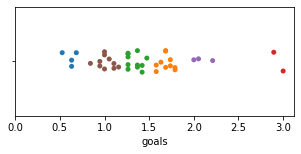

In [15]:
fig, ax = plt.subplots(figsize=(5,2))

sns.stripplot(data=df_average_goals, x='goals', hue='cluster', legend=False, ax=ax, palette='tab10')
ax.set_xlim(xmin=0)

In [16]:
cluster_map_home = df_average_goals_home['cluster'].to_dict()
cluster_map_away = df_average_goals_away['cluster'].to_dict()
cluster_map_home

{'Huddersfield': 0,
 'Brighton': 5,
 'Crystal Palace': 5,
 'Cardiff': 5,
 'Fulham': 5,
 'Burnley': 2,
 'Newcastle': 2,
 'Leicester': 2,
 'Watford': 2,
 'Southampton': 2,
 'Wolves': 2,
 'Everton': 1,
 'Bournemouth': 1,
 'West Ham': 1,
 'Man United': 1,
 'Tottenham': 1,
 'Chelsea': 4,
 'Arsenal': 4,
 'Liverpool': 3,
 'Man City': 3}

In [17]:
df_historical_scores['home_cluster'] = df_historical_scores['home_team'].map(cluster_map_home)
df_historical_scores['away_cluster'] = df_historical_scores['away_team'].map(cluster_map_away)
df_historical_scores

,home_team,away_team,home_goals,away_goals,home_cluster,away_cluster
0,Man United,Leicester,2,1,1,2
1,Bournemouth,Cardiff,2,0,1,0
2,Fulham,Crystal Palace,0,2,5,1
3,Huddersfield,Chelsea,0,3,0,2
4,Newcastle,Tottenham,1,2,2,1
...,...,...,...,...,...,...
375,Liverpool,Wolves,2,0,3,5
376,Man United,Cardiff,0,2,1,0
377,Southampton,Huddersfield,1,1,2,0
378,Tottenham,Everton,2,2,1,2


In [18]:
df_upcoming_season = pd.read_csv(league_data_url_base + str(UPCOMING_SEASON) + league_data_url_end)

In [19]:
df_upcoming_season_fixtures = df_upcoming_season[['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam']]
df_upcoming_season_fixtures = df_upcoming_season_fixtures[(df_upcoming_season_fixtures['HomeTeam']==CLUB_TO_PREDICT) | (df_upcoming_season_fixtures['AwayTeam']==CLUB_TO_PREDICT)]
df_upcoming_season_fixtures

,Div,Date,Time,HomeTeam,AwayTeam
2,E0,14/08/2021,15:00,Burnley,Brighton
15,E0,21/08/2021,17:30,Brighton,Watford
22,E0,28/08/2021,15:00,Brighton,Everton
32,E0,11/09/2021,15:00,Brentford,Brighton
47,E0,19/09/2021,14:00,Brighton,Leicester
59,E0,27/09/2021,20:00,Crystal Palace,Brighton
65,E0,02/10/2021,17:30,Brighton,Arsenal
74,E0,16/10/2021,15:00,Norwich,Brighton
86,E0,23/10/2021,17:30,Brighton,Man City
92,E0,30/10/2021,15:00,Liverpool,Brighton


In [20]:
clubs_in_upcoming_not_in_historical = set(df_upcoming_season_fixtures['HomeTeam']) - set(df_historical_data['HomeTeam'])
clubs_in_upcoming_not_in_historical

{'Aston Villa', 'Brentford', 'Leeds', 'Norwich'}

These clubs are missing from the training data, which means they weren't in the Premier League in the training season(s). We assign them the lowest cluster.

In [21]:
lowest_average_goals_home = df_average_goals_home['goals'].min()
lowest_average_goals_away = df_average_goals_away['goals'].min()

worst_cluster_home = df_average_goals[df_average_goals['goals']==lowest_average_goals_home]['cluster'].to_numpy()[0]
worst_cluster_away = df_average_goals[df_average_goals['goals']==lowest_average_goals_away]['cluster'].to_numpy()[0]

In [22]:
for team in clubs_in_upcoming_not_in_historical:
    cluster_map_home[team ] = worst_cluster_home
    cluster_map_away[team ] = worst_cluster_away

cluster_map_home

{'Huddersfield': 0,
 'Brighton': 5,
 'Crystal Palace': 5,
 'Cardiff': 5,
 'Fulham': 5,
 'Burnley': 2,
 'Newcastle': 2,
 'Leicester': 2,
 'Watford': 2,
 'Southampton': 2,
 'Wolves': 2,
 'Everton': 1,
 'Bournemouth': 1,
 'West Ham': 1,
 'Man United': 1,
 'Tottenham': 1,
 'Chelsea': 4,
 'Arsenal': 4,
 'Liverpool': 3,
 'Man City': 3,
 'Norwich': 0,
 'Leeds': 0,
 'Brentford': 0,
 'Aston Villa': 0}

In [23]:
#df_upcoming_season_fixtures['home_flag'] = np.where(df_upcoming_season_fixtures['HomeTeam'] == CLUB_TO_PREDICT, 1, 0)
#df_upcoming_season_fixtures['perspective'] = CLUB_TO_PREDICT

#df_upcoming_season_fixtures['home_label'] = df_upcoming_season_fixtures['HomeTeam'] + ' home'
#df_upcoming_season_fixtures['away_label'] = df_upcoming_season_fixtures['AwayTeam'] + ' away'

df_upcoming_season_fixtures['home_cluster'] = df_upcoming_season_fixtures['HomeTeam'].map(cluster_map_home)
df_upcoming_season_fixtures['away_cluster'] = df_upcoming_season_fixtures['AwayTeam'].map(cluster_map_away)

#df_upcoming_season_fixtures['opponent'] = np.where(df_upcoming_season_fixtures['HomeTeam'] == CLUB_TO_PREDICT, df_upcoming_season_fixtures['AwayTeam'], df_upcoming_season_fixtures['HomeTeam'])
df_upcoming_season_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,home_cluster,away_cluster
2,E0,14/08/2021,15:00,Burnley,Brighton,2,5
15,E0,21/08/2021,17:30,Brighton,Watford,5,2
22,E0,28/08/2021,15:00,Brighton,Everton,5,2
32,E0,11/09/2021,15:00,Brentford,Brighton,0,5
47,E0,19/09/2021,14:00,Brighton,Leicester,5,2
59,E0,27/09/2021,20:00,Crystal Palace,Brighton,5,5
65,E0,02/10/2021,17:30,Brighton,Arsenal,5,1
74,E0,16/10/2021,15:00,Norwich,Brighton,0,5
86,E0,23/10/2021,17:30,Brighton,Man City,5,4
92,E0,30/10/2021,15:00,Liverpool,Brighton,3,5


In [24]:
df_upcoming_season_fixtures_pred = df_upcoming_season_fixtures[['home_cluster', 'away_cluster']]
df_upcoming_season_fixtures_pred

,home_cluster,away_cluster
2,2,5
15,5,2
22,5,2
32,0,5
47,5,2
59,5,5
65,5,1
74,0,5
86,5,4
92,3,5


In [25]:
clf_home = linear_model.PoissonRegressor(fit_intercept=True, alpha=0)
clf_away = linear_model.PoissonRegressor(fit_intercept=True, alpha=0)


clf_home.fit(df_historical_scores[['home_cluster', 'away_cluster']], df_historical_scores['home_goals'])
clf_away.fit(df_historical_scores[['home_cluster', 'away_cluster']], df_historical_scores['away_goals'])

PoissonRegressor(alpha=0)

In [26]:
home_score_rate = clf_home.predict(df_upcoming_season_fixtures_pred)
away_score_rate = clf_away.predict(df_upcoming_season_fixtures_pred)

df_upcoming_season_fixtures['home_score_rate'] = home_score_rate
df_upcoming_season_fixtures['away_score_rate'] = away_score_rate
df_upcoming_season_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,home_cluster,away_cluster,home_score_rate,away_score_rate
2,E0,14/08/2021,15:00,Burnley,Brighton,2,5,1.412302,1.171739
15,E0,21/08/2021,17:30,Brighton,Watford,5,2,1.620562,1.305802
22,E0,28/08/2021,15:00,Brighton,Everton,5,2,1.620562,1.305802
32,E0,11/09/2021,15:00,Brentford,Brighton,0,5,1.391652,1.141156
47,E0,19/09/2021,14:00,Brighton,Leicester,5,2,1.620562,1.305802
59,E0,27/09/2021,20:00,Crystal Palace,Brighton,5,5,1.443852,1.219156
65,E0,02/10/2021,17:30,Brighton,Arsenal,5,1,1.684147,1.336031
74,E0,16/10/2021,15:00,Norwich,Brighton,0,5,1.391652,1.141156
86,E0,23/10/2021,17:30,Brighton,Man City,5,4,1.500503,1.247380
92,E0,30/10/2021,15:00,Liverpool,Brighton,3,5,1.422741,1.187336


In [35]:
def simulate_goals(score_rate, n_sims=N_SIMS):
    simulated_goals = []
    for i in range(n_sims):
        simulated_goals.append(rng.poisson(score_rate))

    return simulated_goals


In [38]:
df_upcoming_season_fixtures['test_home_goals_sims'] = df_upcoming_season_fixtures['home_score_rate'].apply(lambda x: simulate_goals(x))


In [39]:
df_upcoming_season_fixtures

,Div,Date,Time,HomeTeam,AwayTeam,home_cluster,away_cluster,home_score_rate,away_score_rate,test_home_goals_sims
2,E0,14/08/2021,15:00,Burnley,Brighton,2,5,1.412302,1.171739,"[1, 0, 0, 1, 0, 3, 2, 1, 1, 1, 1, 1, 2, 1, 0, ..."
15,E0,21/08/2021,17:30,Brighton,Watford,5,2,1.620562,1.305802,"[1, 3, 1, 1, 1, 1, 3, 3, 0, 1, 2, 1, 0, 5, 2, ..."
22,E0,28/08/2021,15:00,Brighton,Everton,5,2,1.620562,1.305802,"[3, 1, 0, 0, 1, 2, 0, 2, 3, 0, 1, 1, 1, 3, 1, ..."
32,E0,11/09/2021,15:00,Brentford,Brighton,0,5,1.391652,1.141156,"[2, 0, 2, 2, 2, 3, 0, 2, 3, 1, 1, 1, 3, 3, 0, ..."
47,E0,19/09/2021,14:00,Brighton,Leicester,5,2,1.620562,1.305802,"[3, 0, 3, 2, 2, 6, 2, 3, 3, 3, 3, 1, 2, 3, 2, ..."
59,E0,27/09/2021,20:00,Crystal Palace,Brighton,5,5,1.443852,1.219156,"[1, 3, 1, 0, 1, 1, 2, 3, 0, 1, 1, 3, 0, 2, 2, ..."
65,E0,02/10/2021,17:30,Brighton,Arsenal,5,1,1.684147,1.336031,"[1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, ..."
74,E0,16/10/2021,15:00,Norwich,Brighton,0,5,1.391652,1.141156,"[0, 4, 2, 1, 2, 2, 1, 3, 0, 2, 1, 1, 1, 1, 1, ..."
86,E0,23/10/2021,17:30,Brighton,Man City,5,4,1.500503,1.247380,"[3, 2, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 1, 1, 3, ..."
92,E0,30/10/2021,15:00,Liverpool,Brighton,3,5,1.422741,1.187336,"[3, 3, 0, 2, 0, 2, 1, 2, 2, 0, 1, 2, 1, 1, 3, ..."
